In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [142]:
def square_error(data):
    return (np.subtract(data, data.mean(axis=0))**2).sum()

def dis_kurt(data):
    dis_square = (np.subtract(data, data.mean(axis=0))**2).sum(axis=1)
    output = (dis_square**2).mean()/(dis_square.mean()**2)
    return output

class KMeans():
    def __init__(self, data, seed_clusters=2, min_point=30, max_clusters=100, MCMC=False):
        self.data = np.array(data)
        self.d_n, self.dim = self.data.shape
        self.se = square_error(self.data)
        self.labels = np.zeros((self.d_n))
        self._2nd_labels = -1*np.ones((self.d_n))
        
        self.min_p = min_point
        self.max_c = max_clusters
        
        self.reset_cluster(seed_clusters)
    
    def reset_cluster(self, seed_clusters=2):
        self.clusters = np.zeros((1,self.dim))
        self.clusters[0] = self.data[np.random.randint(self.d_n)]
        if (seed_clusters>=2):
            for t in range(1, seed_clusters):
                if self.clusters.shape[0] >= self.d_n:
                    print("clusters shouldn't be more than data amounts")
                else:
                    temp_peak = self.data[np.random.randint(self.d_n)]
                    while (temp_peak in self.clusters):
                        temp_peak = self.data[np.random.randint(self.d_n)]
                    
                    self.clusters = np.vstack((self.clusters, temp_peak))
    
    def p2c(self, point):
        if len(point) != self.dim:
            print("point dimension error")
        temp_dist = (np.subtract(self.clusters, point)**2).sum(axis=1)**0.5
        return temp_dist.min()
    
    def add_cluster(self, lots=np.zeros((0,0)) ,MCMC_times=0, MCMC_power=1, compare_cluster=-1):
        if lots.shape[0]==0:
            lots = self.data
        temp_peak = lots[np.random.randint(len(lots))]
        if compare_cluster == -1:
            temp_dist = self.p2c(temp_peak)
        elif compare_cluster < self.clusters.shape[0]:
            temp_dist = np.linalg.norm(temp_peak-self.clusters[compare_cluster])
        else:
            print("compare_clusters int and less than cluster_n")
            return("compare_clusters int and less than cluster_n")
        
        if MCMC_times > 0:
            for t in range(MCMC_times):
                backup_peak = lots[np.random.randint(len(lots))]
                if compare_cluster == -1:
                    compare_dist = self.p2c(backup_peak)
                elif compare_cluster < self.clusters.shape[0]:
                    compare_dist = np.linalg.norm(backup_peak-self.clusters[compare_cluster])
                else:
                    print("compare_clusters int and less than cluster_n")
                    return("compare_clusters int and less than cluster_n")
                
                if np.random.rand()*temp_dist**MCMC_power < compare_dist**MCMC_power:
                    temp_peak = backup_peak
        
        self.clusters = np.vstack((self.clusters, temp_peak))
    
    def assign(self, only_label = True):
        self.distance = np.zeros((self.d_n, self.clusters.shape[0]))
        for c in range(self.clusters.shape[0]):
            temp_relate = np.subtract(self.data, self.clusters[c])
            self.distance[:,c] = (0.0001 + (temp_relate**2).sum(axis=1))**0.5
        
        temp_dis_sort = np.argsort(self.distance, axis=1)
        self.labels = temp_dis_sort[:, 0]
        
        if (not only_label):
            if self.clusters.shape[0] >=2:
                self._2nd_labels = temp_dis_sort[:, 1]
            else:
                self._2nd_labels = -1*np.ones((self.d_n))
            
            self.c_se = np.zeros((self.clusters.shape[0]))
            self.c_std = np.zeros((self.clusters.shape[0]))
            self.c_kurt = np.zeros((self.clusters.shape[0]))
            for c in range(self.clusters.shape[0]):
                if (self.labels == c).sum() > 0:
                    self.c_se[c] = square_error(np.compress(self.labels == c, self.data, axis=0)) 
                    self.c_std[c] = self.c_se[c]/(self.labels == c).sum()
                    self.c_kurt[c] = dis_kurt(np.compress(self.labels == c, self.data, axis=0)) 
            
            self.c_std = np.sqrt(0.0001 + self.c_std)
            self.c_dist_cfd = np.zeros((self.clusters.shape[0], 5))
            self.c_fm = np.zeros((self.clusters.shape[0])) # foreign matter
            for c in range(self.clusters.shape[0]):
                temp_c_d = np.subtract(self.data, self.clusters[c])
                temp_c_d = np.sqrt(0.0001+(temp_c_d**2).sum(axis=1))/ self.c_std[c]
                if (self.labels == c).sum()>=2:
                    self.c_fm[c] = ((temp_c_d<2.)*(self.labels != c)).sum()/(self.labels == c).sum()
                
                temp_c_d_c = np.compress(self.labels == c, temp_c_d)
                
                for i in range(5):
                    self.c_dist_cfd[c][i] = (temp_c_d_c < ((i+1)/5)).sum()
                
                self.c_dist_cfd[c] /= (self.labels == c).sum() + 0.0001
    
    def single_fit(self, only_label=True):
        for c in range(self.clusters.shape[0]):
            if (self.labels == c).sum() > 0:
                self.clusters[c] = np.compress(self.labels == c, self.data, axis=0).mean(axis=0)
        
        self.assign(only_label)
    
    def fit(self, max_times=10):
        self.assign()
        for t in range(max_times):
            temp_pre_lables = self.labels
            self.single_fit()
            if np.abs(self.labels - temp_pre_lables).sum() == 0:
                break
        
        self.single_fit(only_label=False)
    
    def drop_cluster(self, c):
        self.clusters = np.vstack((self.clusters[:c], self.clusters[c+1:]))
    
    def cluster_adj_elbow(self, elbow=0.8):
        self.fit()
        while ((self.c_se.sum()/self.se) > (1-elbow)):
            self.add_cluster(MCMC_times=20)
            self.fit()
    
    def cluster_adj_kurt(self, kurt_sup=2.5):
        for c in range(self.clusters.shape[0]):
            if self.c_kurt[c] > kurt_sup:
                self.add_cluster(lots=np.compress(self.labels == c, self.data, axis=0), MCMC_times=20, compare_cluster=c)
                self.fit()
        
    def cluster_adj_discreted(self):
        for c in range(self.clusters.shape[0]):
            for l in range(5):
                if self.c_dist_cfd[c][l] < 0.8*(np.sqrt(self.dim/(self.dim+2))**self.dim)*(((l+1)/5)**self.dim):
                    self.add_cluster(lots=np.compress(self.labels == c, self.data, axis=0), MCMC_times=20, compare_cluster=c)
                    self.fit()
    
    def cluster_adj_excessive(self, foreign_matter = 1.):
        kiling = True
        while kiling:
            for c in range(self.clusters.shape[0]):
                if self.c_fm[c] > foreign_matter:
                    self.drop_cluster(c)
                    self.fit()
                    break
                
                if c == (self.clusters.shape[0]-1):
                    kiling = False
        
    def predict(self, data):
        if data.shape[1] != self.dim:
            print("data size error")
            return ("data size error")
        
        temp_distance = np.zeros((data.shape[0], self.clusters.shape[0]))
        for c in range(self.clusters.shape[0]):
            temp_relate = np.subtract(data, self.clusters[c])
            temp_distance[:,c] = (0.0001 + (temp_relate**2).sum(axis=1))**0.5
        
        temp_dis_sort = np.argsort(temp_distance, axis=1)
        out_put = temp_dis_sort[:, 0]
        return out_put
    
    def auto_clustering(self, elbow=0.8, kurt_sup=2.5, foreign_matter = 1.):
        self.fit()
        while ((self.c_se.sum()/self.se) > (1-elbow)):
            self.add_cluster(MCMC_times=20)
            self.fit()
            print("varrance large")

        for c in range(self.clusters.shape[0]):
            if self.c_kurt[c] > kurt_sup:
                self.add_cluster(lots=np.compress(self.labels == c, self.data, axis=0), MCMC_times=20, compare_cluster=c)
                self.fit()
                print("kurt large")
        
        for c in range(self.clusters.shape[0]):
            for l in range(5):
                if self.c_dist_cfd[c][l] < 0.8*(np.sqrt(self.dim/(self.dim+2))**self.dim)*(((l+1)/5)**self.dim):
                    self.add_cluster(lots=np.compress(self.labels == c, self.data, axis=0), MCMC_times=20, compare_cluster=c)
                    self.fit()
                    print("empty center")
                    break
        
        kiling = True
        while kiling:
            for c in range(self.clusters.shape[0]):
                if self.c_fm[c] > foreign_matter:
                    self.drop_cluster(c)
                    self.fit()
                    break
                
                if c == (self.clusters.shape[0]-1):
                    kiling = False
    
    def silhouette(self, data):
        temp_c_n = self.clusters.shape[0]
        temp_labels = self.predict(data)
        tamp_d_stack_M = np.repeat(data, data.shape[0], axis = 0).reshape(data.shape[:1]+ data.shape)
        temp_dist_matrix = np.linalg.norm(tamp_d_stack_M - np.transpose(tamp_d_stack_M, (1,0,2)), axis=2)
        temp_dissimilar = np.zeros((data.shape[0], temp_c_n))
        for c in range(temp_c_n):
            temp_dissimilar[:,c] = np.compress(temp_labels == c, temp_dist_matrix, axis=1).sum(axis=1)
        
        temp_label_counter = np.bincount(temp_labels, minlength=temp_c_n)
        temp_label_is = np.zeros(temp_dissimilar.shape, dtype=int)
        for c in range(temp_c_n):
            temp_label_is [:,c] = (temp_labels == c)
        
        temp_label_counter = np.repeat(temp_label_counter.reshape(1, temp_c_n), data.shape[0], axis=0)
        temp_label_counter -= temp_label_is
        temp_dissimilar /= temp_label_counter 
        a = (temp_dissimilar*temp_label_is).max(axis = 1)
        b = (temp_dissimilar + temp_label_is*temp_dissimilar.max()).min(axis = 1)
        s = (b - a) / (a*(a>=b) + b*(b>a))
        output = (s.mean(), np.zeros((temp_c_n)), s, temp_labels)
        # out_put provide (totally score, cluster wise score, data wise score, data label)
        for c in range(temp_c_n):
            output[1][c] = np.compress(temp_labels == c, s).mean()
        
        return output

[0, 0] 1
[ -1.98825764 -16.35370883] 0.37793487158094563
[ 0.8409443   3.92699546] 0.603558525819684
[ 16.9369187   16.90355889] 0.19408694309110933
[-18.19974582   2.06900886] 1.0569757494632939
[ 19.43356732   3.86253195] 0.7191507044992619
[ 8.44263087 -4.36745823] 0.7607238056463691
[ 16.78333086  -8.77821488] 1.0157290723138528
[ 1.05892078 -4.74375211] 0.9816199005407258
[-10.9734528   -0.99664878] 0.9319660586108782


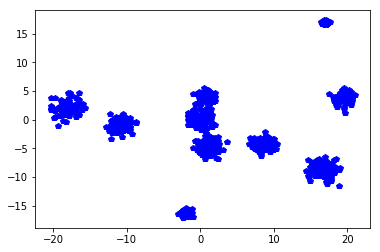

In [143]:
foo = np.random.normal(0,1,(100,2))
print([0,0],1)

for t in range(1,10):
    c = np.random.rand((2))*40 - 20
    s = np.random.rand() + 0.1
    foo = np.vstack((foo, np.random.normal(0,s, (100,2)) + c))
    print(c,s)

plt.plot(foo.T[0], foo.T[1] , "bp")
plt.show()

In [170]:
k_mean = KMeans(foo, seed_clusters=2)
k_mean.fit()

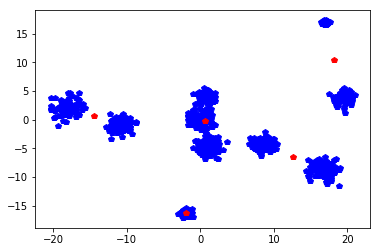

In [172]:
while k_mean.silhouette(k_mean.data)[1].min() <0.5:
    c = np.argmin(k_mean.silhouette(k_mean.data)[1])
    k_mean.add_cluster(lots=np.compress(k_mean.labels == c, k_mean.data, axis=0), MCMC_times=20, compare_cluster=c)
    k_mean.fit()
    
plt.plot(foo.T[0], foo.T[1], "bp", k_mean.clusters.T[0], k_mean.clusters.T[1], "rp")
plt.show()


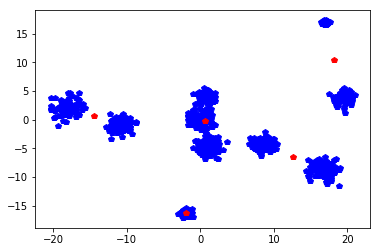

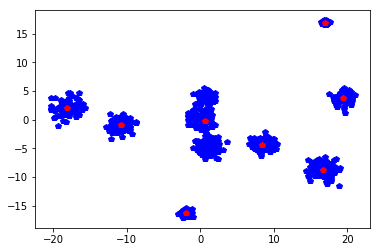

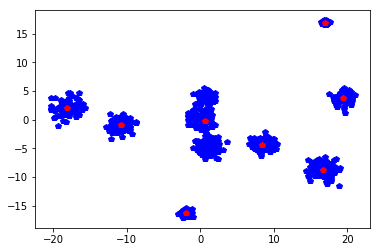

In [174]:
k_mean.cluster_adj_elbow(0.8)

plt.plot(foo.T[0], foo.T[1], "bp", k_mean.clusters.T[0], k_mean.clusters.T[1], "rp")
plt.show()

k_mean.cluster_adj_discreted()

plt.plot(foo.T[0], foo.T[1], "bp", k_mean.clusters.T[0], k_mean.clusters.T[1], "rp")
plt.show()


k_mean.cluster_adj_excessive(1.)

plt.plot(foo.T[0], foo.T[1], "bp", k_mean.clusters.T[0], k_mean.clusters.T[1], "rp")
plt.show()



In [173]:
k_mean.silhouette(k_mean.data)[1]

array([ 0.57800959,  0.959661  ,  0.56260847,  0.65893739,  0.67154381])

t =  1
2 0.415785254181 se large
3 0.0501319792329 se large
4 0.049997069737 outlier large
5 0.0499001481825 central empty level 1
4 0.0499971131015 clus kill
3 0.0501319792329 clus kill
t =  2
4 0.0499938105358 outlier large
3 0.0501319792329 clus kill
t =  3
4 0.0499959559327 outlier large
5 0.0498996412137 central empty level 1
4 0.0499921557515 clus kill
3 0.0501319792329 clus kill
t =  4
4 0.0499918515797 outlier large
3 0.0501319792329 clus kill
t =  5
4 0.0499916299528 outlier large
5 0.0498998477996 central empty level 1
4 0.0499917282648 clus kill
3 0.0501319792329 clus kill
t =  6
4 0.0499934068399 outlier large
5 0.0498993485822 central empty level 1
6 0.0498569690851 central empty level 1
5 0.0498993640054 clus kill
4 0.0499932725109 clus kill
3 0.0501319792329 clus kill
t =  7
4 0.0499915774675 outlier large
5 0.0498998446193 central empty level 1
6 0.0498565975224 central empty level 1
5 0.0498998256901 clus kill
4 0.0499917201472 clus kill
3 0.0501319792329 clus kill
t =

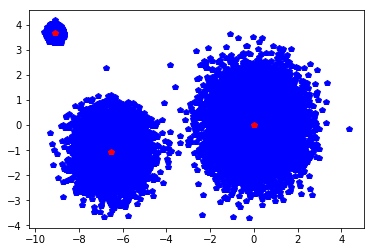

In [249]:
k_mean = KMeans(foo, seed_clusters=1)
k_mean.fit()

for t in range(20):
    print("t = ", t+1)
    round_down = False
    
    while (k_mean.c_se.sum()/k_mean.se > 0.2):
        k_mean.add_cluster(MCMC_times=10)
        k_mean.fit()
        print (k_mean.clusters.shape[0], k_mean.c_se.sum()/k_mean.se, "se large")
    
    for c in range(k_mean.clusters.shape[0]):
        if k_mean.c_kurt[c] > 2.5:
            k_mean.add_cluster(lots=np.compress(k_mean.labels == c, k_mean.data, axis=0), MCMC_times=10)
            k_mean.fit()
            print (k_mean.clusters.shape[0], k_mean.c_se.sum()/k_mean.se, "outlier large")
            round_down = True
    
    for c in range(k_mean.clusters.shape[0]):
        for l in range(10):
            if k_mean.c_dist_cfd[c][l] < 0.8*0.5*(((l+1)/10)**2):
                k_mean.add_cluster(lots=np.compress(k_mean.labels == c, k_mean.data, axis=0), MCMC_times=10)
                k_mean.fit()
                print (k_mean.clusters.shape[0], k_mean.c_se.sum()/k_mean.se, "central empty level", l+1)
                round_down = True
                break
    
    kiling = True
    while kiling:
        for c in range(k_mean.clusters.shape[0]):
            if k_mean.c_fm[c] > 0.8:
                k_mean.drop_cluster(c)
                k_mean.fit()
                print (k_mean.clusters.shape[0], k_mean.c_se.sum()/k_mean.se, "clus kill")
                break
                
            if c == (k_mean.clusters.shape[0]-1):
                kiling = False

plt.plot(foo.T[0], foo.T[1], "bp", k_mean.clusters.T[0], k_mean.clusters.T[1], "rp")
plt.show()

(51, 2)

In [225]:
k_mean.c_kurt

array([ 2.03775184,  1.55205297,  2.05817609,  2.00522185,  1.73180724,
        1.91252577,  1.87866471,  1.61301695,  1.93293163,  1.51981178,
        1.90691481,  3.5648273 ,  2.19158838,  3.37972324,  2.38886392])

In [179]:
k_mean.clusters

array([[ -6.04003616, -17.25278967],
       [-19.28667328,   6.95255462],
       [ 16.90977469,  11.59214431],
       [ -0.37339949,  -0.65394102],
       [  2.48468875, -18.68920762],
       [-17.41706018,  -4.61499276],
       [  3.71926191,  19.10964371]])

In [125]:
np.sqrt(k_mean.c_se[3]/(k_mean.labels == 3).sum())

IndexError: index 3 is out of bounds for axis 0 with size 2

In [137]:
foo = np.array([[0,0,0,0], [-10, -0.1, 0.1, 10]]).T

In [138]:
k_mean =KMeans(data=foo, seed_clusters=1)

In [139]:
k_mean.clusters = np.array([[0,-1],[0,1]])
k_mean.fit()

In [140]:
k_mean.clusters

array([[ 0, -5],
       [ 0,  5]])

In [141]:
k_mean.silhouette(k_mean.data)

dissimilar =  [[  9.9   15.05]
 [  9.9    5.15]
 [  5.15   9.9 ]
 [ 15.05   9.9 ]]
labels =  [0 0 1 1]
label_is =  [[1 0]
 [1 0]
 [0 1]
 [0 1]]
a =  [ 9.9  9.9  9.9  9.9]
b =  [ 15.05   5.15   5.15  15.05]


(-0.068802644384039768,
 array([-0.06880264, -0.06880264]),
 array([ 0.34219269, -0.47979798, -0.47979798,  0.34219269]),
 array([0, 0, 1, 1]))

In [190]:
def erf(x, Taylor=100):
    temp = x*np.sqrt(0.5)
    output = 0
    for t in range(Taylor+1):
        output += temp/(2*t+1)
        temp *= -(x**2)/(2*t+2)
    
    return 2*output/np.sqrt(np.pi)

In [203]:
for i in range(1,6):
    print(erf(0.2*i))

0.158519418878
0.310843483221
0.4514937645
0.576289202833
0.682689492137


In [25]:
from scipy import misc

In [88]:
img = misc.imread("../Koi/Sample/S__5693478.jpg")

In [89]:
s_img = img[:,:,:3].reshape(img.shape[0]*img.shape[1], 3).astype("float64")

In [90]:
s_img -= s_img.min()
s_img *= 254./s_img.max()

In [91]:
k_means = KMeans(s_img)

In [92]:
k_means.clusters = np.zeros([9,3])

In [93]:
for i in range(8):
    k_means.clusters[i] = 64.*np.ones((3))+np.array([i%2, int(i/2)%2, int(i/4)%4])*128.

k_means.clusters[8] = np.array([128,128,128])

In [94]:
k_means.assign()

In [95]:
img_f = np.array(img).reshape(img.shape[0]*img.shape[1], 3)

In [96]:
for i in range(img_f.shape[0]):
    img_f[i,:3] = k_means.clusters[k_means.labels[i]]

In [60]:
img_filter = np.zeros(img.shape[:2])
for i in [2,4,6]:
    img_filter += img_f[:,:,i]
img_filter  = (img_filter == 0)
plt.imshow(img_filter.astype(int))
plt.show()

IndexError: too many indices for array

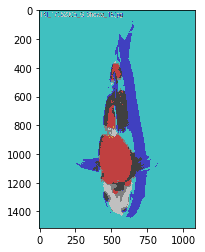

In [97]:
plt.imshow((img_f.reshape(img.shape)))
plt.show()

In [68]:
img_f[:,3]>0

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [122]:
a = np.array([[0,1], [1,0]])
b = np.array([[0, np.inf], [np.inf, 0]])

In [123]:
print(a)
print(b)

[[0 1]
 [1 0]]
[[  0.  inf]
 [ inf   0.]]
